<a href="https://colab.research.google.com/github/tade0726/DL-2021S2/blob/main/DL_assessment_3_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [65]:
! pip install --quiet "torchmetrics>=0.3" "torch==1.9" "torchvision" "lightning-bolts" "pytorch-lightning>=1.3"

In [66]:
from os.path import join

from time import time

import numpy as np
import pandas as pd
pd.options.display.float_format = '{:,.5f}'.format

# Sklearn tools
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Neural Networks
import torch
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader

import pytorch_lightning as pl
from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.loggers.csv_logs import CSVLogger

# Plotting
%matplotlib inline
import matplotlib.pyplot as plt

In [67]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## define model

In [68]:
class TimeseriesDataset(Dataset):   
    '''
    Custom Dataset subclass. 
    Serves as input to DataLoader to transform X 
      into sequence data using rolling window. 
    DataLoader using this dataset will output batches 
      of `(batch_size, seq_len, n_features)` shape.
    Suitable as an input to RNNs. 
    '''
    def __init__(self, X: np.ndarray, y: np.ndarray, seq_len: int = 1):
        self.X = torch.tensor(X).float()
        self.y = torch.tensor(y).float()
        self.seq_len = seq_len

    def __len__(self):
        return self.X.__len__() - (self.seq_len-1)

    def __getitem__(self, index):
        return (self.X[index:index+self.seq_len], self.y[index+self.seq_len-1])

In [69]:
class DataModule(pl.LightningDataModule):
    '''
    PyTorch Lighting DataModule subclass:
    https://pytorch-lightning.readthedocs.io/en/latest/datamodules.html

    Serves the purpose of aggregating all data loading 
      and processing work in one place.
    '''
    
    def __init__(self, seq_len = 1, batch_size = 128, num_workers=0):

        super().__init__()
        self.seq_len = seq_len
        self.batch_size = batch_size
        self.num_workers = num_workers

        self.X_train = None
        self.y_train = None

        self.X_val = None
        self.y_val = None

        self.X_test = None
        self.X_test = None

        self.columns = None
        self.preprocessing = None

        # csv

        self.df_train = None
        self.df_test = None

    def prepare_data(self):
        pass

    def setup(self, stage=None):
        '''
        Data is resampled to hourly intervals.
        Both 'np.nan' and '?' are converted to 'np.nan'
        'Date' and 'Time' columns are merged into 'dt' index
        '''

        if stage == 'fit' and self.X_train is not None:
            return 
        if stage == 'test' and self.X_test is not None:
            return
        if stage is None and self.X_train is not None and self.X_test is not None:  
            return
        
        data_dir = "./drive/MyDrive/adelaide/Uni/2021S2/DL/DL-asset-3/data"

        train_data_name = "Google_Stock_Price_Train.csv"
        test_data_name = "Google_Stock_Price_Test.csv"

        def load_csv(path):
          df = pd.read_csv(
            path, 
            parse_dates={'dt' : ['Date']}, 
            infer_datetime_format=True, 
            thousands=",",
            low_memory=False, 
            index_col='dt')          
          return df        

        df_train = load_csv(join(data_dir, train_data_name))
        df_test = load_csv(join(data_dir, test_data_name))


        self.df_train = df_train
        self.df_test = df_test

        # drop some features
        # drop_columns = ["Volume", "High", "Low", "Open"]
        drop_columns = ["Volume"]
    
        df_train = df_train.drop(drop_columns, 1)
        df_test = df_test.drop(drop_columns, 1)

        df_train = df_train.sort_index(axis=0)

        num_test = df_test.shape[0]
        num_train = df_train.shape[0]

        df_val = df_train.tail(num_test)
        df_train = df_train.head(num_train - num_test)


        def get_target(df, name:str):
          y_return = df[name]
          y_return = y_return.shift(-1).ffill()
          return y_return

        target_name = "Close"

        y_val = get_target(df_val, target_name)
        y_train = get_target(df_train, target_name)
        y_test = get_target(df_test, target_name)

        self.columns = df_train.columns

        # normalized
        preprocessing = StandardScaler()
        preprocessing.fit(df_train)

        # exculded the last sample
        if stage == 'fit' or stage is None:
            self.X_train = preprocessing.transform(df_train)[:-1]
            self.y_train = y_train.values.reshape((-1, 1))[:-1]

            self.X_val = preprocessing.transform(df_val)[:-1]
            self.y_val = y_val.values.reshape((-1, 1))[:-1]

        if stage == 'test' or stage is None:
            self.X_test = preprocessing.transform(df_test)[:-1]
            self.y_test = y_test.values.reshape((-1, 1))[:-1]

    def train_dataloader(self):
        train_dataset = TimeseriesDataset(self.X_train, 
                                          self.y_train, 
                                          seq_len=self.seq_len)
        
        train_loader = DataLoader(train_dataset, 
                                  batch_size = self.batch_size, 
                                  shuffle = False, 
                                  num_workers = self.num_workers)
        
        return train_loader

    def val_dataloader(self):
        val_dataset = TimeseriesDataset(self.X_val, 
                                        self.y_val, 
                                        seq_len=self.seq_len)
        val_loader = DataLoader(val_dataset, 
                                batch_size = 1, 
                                shuffle = False, 
                                num_workers = self.num_workers)

        return val_loader

    def test_dataloader(self):
        test_dataset = TimeseriesDataset(self.X_test, 
                                         self.y_test, 
                                         seq_len=self.seq_len)
        test_loader = DataLoader(test_dataset, 
                                 batch_size = 1, 
                                 shuffle = False, 
                                 num_workers = self.num_workers)

        return test_loader

In [70]:
class LSTMRegressor(pl.LightningModule):
    '''
    Standard PyTorch Lightning module:
    https://pytorch-lightning.readthedocs.io/en/latest/lightning_module.html
    '''
    def __init__(self, 
                 n_features, 
                 hidden_size, 
                 seq_len, 
                 batch_size,
                 num_layers, 
                 dropout, 
                 learning_rate,
                 criterion):
        super(LSTMRegressor, self).__init__()
        self.n_features = n_features
        self.hidden_size = hidden_size
        self.seq_len = seq_len
        self.batch_size = batch_size
        self.num_layers = num_layers
        self.dropout = dropout
        self.criterion = criterion
        self.learning_rate = learning_rate

        self.lstm = nn.LSTM(input_size=n_features, 
                            hidden_size=hidden_size,
                            num_layers=num_layers, 
                            dropout=dropout, 
                            batch_first=True)
        self.linear = nn.Linear(hidden_size, 1)
        
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        y_pred = self.linear(lstm_out[:,-1])
        return y_pred
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate)

    def evaluate(self, batch, stage=None):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        self.log(f'{stage}_loss', loss)
        r2 = self.r2_loss(y_hat, y)
        self.log("r2", r2)
        return loss

    def training_step(self, batch, batch_idx):
        return self.evaluate(batch, stage="train")

    def validation_step(self, batch, batch_idx):
        return self.evaluate(batch, stage="val")

    def test_step(self, batch, batch_idx):
        return self.evaluate(batch, stage="test")

    def r2_loss(self, y_hat, y):
        y_mean = torch.mean(y)
        ss_tot = torch.sum((y - y_mean) ** 2)
        ss_res = torch.sum((y - y_hat) ** 2)
        r2 = 1 - ss_res / ss_tot
        return r2


class GRURegressor(LSTMRegressor):

    def __init__(self, 
              n_features, 
              hidden_size, 
              seq_len, 
              batch_size,
              num_layers, 
              dropout, 
              learning_rate,
              criterion):
      super(GRURegressor, self).__init__()
      
      self.n_features = n_features
      self.hidden_size = hidden_size
      self.seq_len = seq_len
      self.batch_size = batch_size
      self.num_layers = num_layers
      self.dropout = dropout
      self.criterion = criterion
      self.learning_rate = learning_rate

      self.lstm = nn.GRU(input_size=n_features, 
                          hidden_size=hidden_size,
                          num_layers=num_layers, 
                          dropout=dropout, 
                          batch_first=True)
      self.linear = nn.Linear(hidden_size, 1)

## Parameters

In [71]:
class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self

p = AttrDict(
    seq_len = 7,
    batch_size = 5,
    criterion = nn.MSELoss(),
    max_epochs = 100,
    n_features = 4,
    hidden_size = 64,
    num_layers = 3,
    dropout = 0.2,
    learning_rate = 0.01
)

In [72]:
## train loop

seed_everything(1)

exp_dir = "./drive/MyDrive/adelaide/Uni/2021S2/DL/DL-asset-3/exps"
metrics_folder_name = "-".join([f"{k}:{v}" for k,v in p.items()])
csv_logger = CSVLogger(exp_dir, name=f'lstm', version=metrics_folder_name),


trainer = Trainer(
    max_epochs=p.max_epochs,
    logger=csv_logger,
    gpus=1,
    progress_bar_refresh_rate=2,
)

model = LSTMRegressor(
    n_features = p.n_features,
    hidden_size = p.hidden_size,
    seq_len = p.seq_len,
    batch_size = p.batch_size,
    criterion = p.criterion,
    num_layers = p.num_layers,
    dropout = p.dropout,
    learning_rate = p.learning_rate
)

dm = DataModule(
    seq_len = p.seq_len,
    batch_size = p.batch_size
)

Global seed set to 1
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [73]:
import time

meta_data = {}

def main():
  tic = time.perf_counter()
  
  trainer.fit(model, dm)
  trainer.test(model, datamodule=dm)

  toc = time.perf_counter()
  elapsed_time = toc - tic
  return {"elapsed_time": elapsed_time}


meta_data_update = main()
meta_data.update(meta_data_update)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/loggers/csv_logs.py:58: UserWarning: Experiment logs directory ./drive/MyDrive/adelaide/Uni/2021S2/DL/DL-asset-3/exps/lstm/seq_len:7-batch_size:5-criterion:MSELoss()-max_epochs:100-n_features:4-hidden_size:64-num_layers:3-dropout:0.2-learning_rate:0.01 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  f"Experiment logs directory {self.log_dir} exists and is not empty."

  | Name      | Type    | Params
--------------------------------------
0 | criterion | MSELoss | 0     
1 | lstm      | LSTM    | 84.5 K
2 | linear    | Linear  | 65    
--------------------------------------
84.5 K    Trainable params
0         Non-trainable params
84.5 K    Total params
0.338     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 1


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'r2': -inf, 'test_loss': 1747.1353759765625}
--------------------------------------------------------------------------------


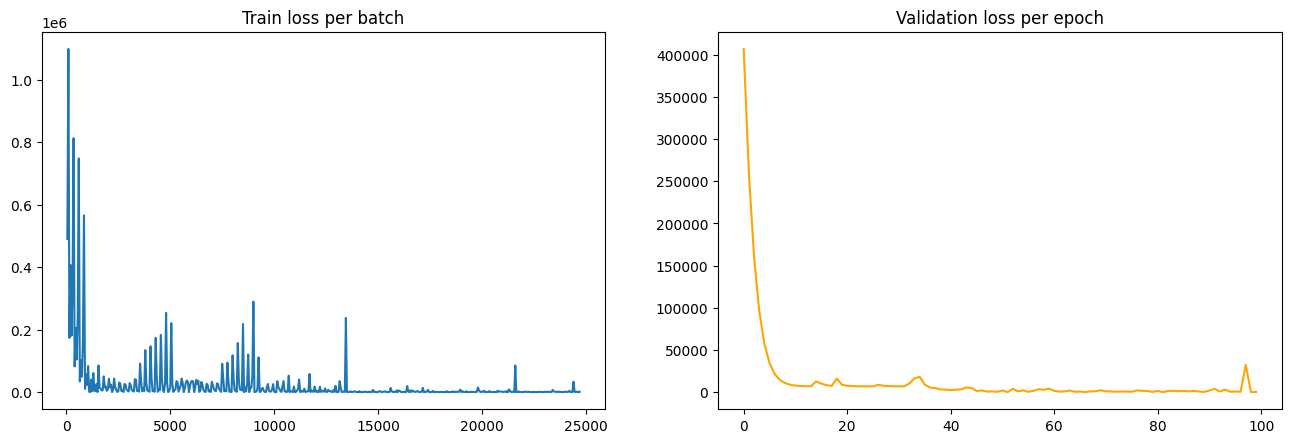

MSE:
Train loss: 1183.924
Val loss:   244.538
Test loss:  1747.135


In [74]:
## Plot report

metrics = pd.read_csv(f'{exp_dir}/lstm/{metrics_folder_name}/metrics.csv')
train_loss = metrics[['train_loss', 'step', 'epoch']][~np.isnan(metrics['train_loss'])]
val_loss = metrics[['val_loss', 'epoch']][~np.isnan(metrics['val_loss'])]
test_loss = metrics['test_loss'].iloc[-1]

fig, axes = plt.subplots(1, 2, figsize=(16, 5), dpi=100)
axes[0].set_title('Train loss per batch')
axes[0].plot(train_loss['step'], train_loss['train_loss'])
axes[1].set_title('Validation loss per epoch')
axes[1].plot(val_loss['epoch'], val_loss['val_loss'], color='orange')
plt.show(block = True)
fig.savefig(f'{exp_dir}/lstm/{metrics_folder_name}/loss.png', dpi=fig.dpi)

print('MSE:')
print(f"Train loss: {train_loss['train_loss'].iloc[-1]:.3f}")
print(f"Val loss:   {val_loss['val_loss'].iloc[-1]:.3f}")
print(f'Test loss:  {test_loss:.3f}')

In [75]:

meta_data_update = {
    "train_loss": train_loss['train_loss'].iloc[-1],
    "val_loss": val_loss['val_loss'].iloc[-1],
    "test_loss": test_loss
}

meta_data.update(meta_data_update)

In [76]:
# dump meta data
import json

json_file_path = join(exp_dir, "lstm", metrics_folder_name)

with open(f'{json_file_path}/meta_data.json', 'wt') as outfile:
    json.dump(meta_data, outfile)

In [77]:
!ls {exp_dir}/lstm/

'seq_len:14-batch_size:10-criterion:MSELoss()-max_epochs:100-n_features:1-hidden_size:64-num_layers:3-dropout:0.2-learning_rate:0.01'
'seq_len:14-batch_size:5-criterion:MSELoss()-max_epochs:100-n_features:1-hidden_size:64-num_layers:3-dropout:0.2-learning_rate:0.01'
'seq_len:7-batch_size:10-criterion:MSELoss()-max_epochs:100-n_features:1-hidden_size:64-num_layers:3-dropout:0.2-learning_rate:0.01'
'seq_len:7-batch_size:15-criterion:MSELoss()-max_epochs:100-n_features:1-hidden_size:64-num_layers:3-dropout:0.2-learning_rate:0.01'
'seq_len:7-batch_size:20-criterion:MSELoss()-max_epochs:100-n_features:1-hidden_size:64-num_layers:3-dropout:0.2-learning_rate:0.01'
'seq_len:7-batch_size:30-criterion:MSELoss()-max_epochs:100-n_features:1-hidden_size:64-num_layers:3-dropout:0.2-learning_rate:0.01'
'seq_len:7-batch_size:5-criterion:MSELoss()-max_epochs:100-n_features:1-hidden_size:64-num_layers:3-dropout:0.2-learning_rate:0.01'
'seq_len:7-batch_size:5-criterion:MSELoss()-max_epochs:100-n_features

In [78]:
y_predicts = []
y_trues = []


for idx, (X, y) in enumerate(dm.val_dataloader()):
  yhat = model(X)

  for x in yhat.tolist():
    y_predicts.extend(x)
  
  for x in y.tolist():
    y_trues.extend(x)


for idx, (X, y) in enumerate(dm.test_dataloader()):
  yhat = model(X)

  for x in yhat.tolist():
    y_predicts.extend(x)
  
  for x in y.tolist():
    y_trues.extend(x)

In [79]:
y_true_arr = np.array(y_trues)
y_predict_arr = np.array(y_predicts)

df = pd.DataFrame({"true": y_true_arr, "predict": y_predict_arr})

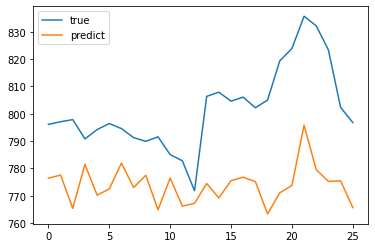

In [80]:
plot = df.plot()
fig = plot.get_figure()
fig.savefig(f'{exp_dir}/lstm/{metrics_folder_name}/test_prediction.png', dpi=fig.dpi)